In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


def get_cmap_rgb(cmap, n_colors=256):
    """Enter a matplotlib colormap name, return rgb array
    Parameters
    ----------
    cmap : str or colormap object
        if matplotlib color, should be string to make sure
        n_colors is selected correctly. If cmocean, pass the object
        e.g.
            matplotlib :  get_cmap_rgb('viridis',10)
            cmocean : get_cmap_rgb(cmocean.cm.thermal,10)
    n_colors : int, optional
        number of color levels in color map
    """

    return cm.get_cmap(cmap,n_colors)(range(n_colors))

def plot_normal(x, y, data, 
				cmap = 'RdBu_r', nbins = 100, 
				fig= None, ax=None,
				cbar_label = None, 
				**kwargs):
	
	"""
	x : 1D array of x-axis co-ordinates
	y : 1D array of y-axis co-ordinates
	data : The field that gets plotted, a 2D array
	fig : matplotlib.figure, optional
    ax : matplotlib.axes, optional
        to make plot at
    cmap : str, optional
        specifies colormap
    cbar_label : str, optional
        label for colorbar, default grabs units from DataArray
    kwargs
        passed to matpotlib.pyplot.contourf
    Returns
    -------
    ax : matplotlib.axes
        if one is not provided
    """

	return_ax = False
	if ax is None:
		fig, ax = plt.subplots()
		return_ax = True

	### fig is like the paper
	### ax is like a particular figure on a paper
	### when you use plt.plot() it implicitly creates a figure and axis by itself. 
	
	im = ax.contourf(x, y, data, nbins, cmap = plt.set_cmap(cmap), **kwargs)

	### Locate ax and apend axis cax to it
	divider = make_axes_locatable(ax)
	cax = divider.append_axes('right', size='5%', pad=0.05)

	### Mount colorbar on cax
	colorbar = fig.colorbar(im, cax=cax)

	if cbar_label is not None:
		colorbar.set_label(str(cbar_label))
	else:
		colorbar.set_label("Color scheme")
        
	if return_ax:
		return ax

def plot_log(x, y, data, 
			nbins=None, bin_edges=None,
			cmap = 'RdBu_r', 
			fig= None, ax=None,
			cbar_label = None, 
			**kwargs):

	"""
	x : 1D array of x-axis co-ordinates
	y : 1D array of y-axis co-ordinates
	data : The field that gets plotted, a 2D array
    nbins : int, optional
        number of colored bin (centers) positive and negative values
        i.e. we get 2*nbins+1, bins. one is neutral (middle)
    bin_edges : array-like, optional
        exclusive with nbins, specify bin edges (positive only)
    fig : matplotlib.figure, optional
    ax : matplotlib.axes, optional
        to make plot at
    cmap : str, optional
        specifies colormap
    cbar_label : str, optional
        label for colorbar, default grabs units from DataArray
    kwargs
        passed to matpotlib.pyplot.contourf
    Returns
    -------
    ax : matplotlib.axes
        if one is not provided
    """

	return_ax = False
	if ax is None:
		fig, ax = plt.subplots()
		return_ax = True	
	if nbins is not None and bin_edges is not None:
		raise TypeError('one or the other')

	log = np.log10(np.abs(data))
	log = np.where((~np.isnan(log)) & (~np.isinf(log)), log, 0.)
    
	if nbins is not None:
		_,bin_edges = np.histogram(log,bins=nbins)
	else:
		nbins = len(bin_edges)-1

	logbins=np.round(bin_edges)

	# determine if colorbar will be extended
	maxExtend = np.any((data>10**logbins[-1]))
	minExtend = np.any((data<-10**logbins[-1]))
	extend='neither'
	if minExtend and maxExtend:
	    extend='both'
	elif maxExtend:
	    extend='max'
	elif minExtend:
	    extend='min'
	# determine number of colors, adding one for each extension
	# and always one extra, the middle color bin
	ncolors=2*nbins+1
	ncolors = ncolors+1 if maxExtend else ncolors
	ncolors = ncolors+1 if minExtend else ncolors
	# if only one end is extended,
	# chop off the extreme value from the other end to fit
	# in the middle (neutral) colorbin
	if extend in ['min' ,'max']:
		cmap = get_cmap_rgb(cmap,ncolors+1)
		bot =  np.arange(1,nbins+1) if extend=='max' else np.arange(0,nbins+1)
		top = np.arange(ncolors-nbins,ncolors) if extend=='min' else np.arange(ncolors-nbins,ncolors+1)
		index = list(bot)+[nbins+1]+list(top)
		cmap = cmap[index,:]
	else:
		cmap=get_cmap_rgb(cmap,ncolors)

	# levels and plot
	levels=10**logbins
	levels = np.concatenate([-levels[::-1],levels],axis=0)
	im=ax.contourf(x, y, data, levels=levels, colors=cmap, extend=extend, **kwargs)

	### Locate ax and apend axis cax to it
	divider = make_axes_locatable(ax)
	cax = divider.append_axes('right', size='5%', pad=0.05)

	### Mount colorbar on cax
	colorbar = fig.colorbar(im, cax=cax)

	if cbar_label is not None:
		colorbar.set_label(str(cbar_label))
	else:
		colorbar.set_label("Color scheme")

	ticklabels = [f'-10^{b:.0f}' for b in logbins[::-1]]
	ticklabels += [f'10^{b:.0f}' for b in logbins]
	colorbar.set_ticklabels(ticklabels)

	if return_ax:
		return ax



In [2]:
filename = "h_c_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)

x = np.unique(data[:,0])
y = np.unique(data[:,1])
h_c_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "h_c_adjoint_old.dat"
data = np.loadtxt(filename, skiprows = 2)
h_c_adjoint_old = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "h_c_grdchk_1e3.dat"
data = np.loadtxt(filename, skiprows = 2)
h_c_grdchk_1e3 = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "h_c_grdchk_5e2.dat"
data = np.loadtxt(filename, skiprows = 2)
h_c_grdchk_5e2 = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "h_c_forward.dat"
data = np.loadtxt(filename, skiprows = 2)
h_c_forward = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "vx_c_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)
vx_c_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "vx_c_grdchk_1e3.dat"
data = np.loadtxt(filename, skiprows = 2)
vx_c_grdchk_1e3 = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "vx_c_grdchk_5e2.dat"
data = np.loadtxt(filename, skiprows = 2)
vx_c_grdchk_5e2 = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "vx_c_forward.dat"
data = np.loadtxt(filename, skiprows = 2)
vx_c_forward = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "q_geo_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)
q_geo_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "q_geo_grdchk_1e3.dat"
data = np.loadtxt(filename, skiprows = 2)
q_geo_grdchk_1e3 = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "q_geo_grdchk_5e2.dat"
data = np.loadtxt(filename, skiprows = 2)
q_geo_grdchk_5e2 = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "q_geo_forward.dat"
data = np.loadtxt(filename, skiprows = 2)
q_geo_forward = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "dzs_dxi_g_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)
dzs_dxi_g_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "dzs_dxi_g_grdchk_1e3.dat"
data = np.loadtxt(filename, skiprows = 2)
dzs_dxi_g_grdchk_1e3 = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "dzs_dxi_g_grdchk_5e2.dat"
data = np.loadtxt(filename, skiprows = 2)
dzs_dxi_g_grdchk_5e2 = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "dzs_dxi_g_forward.dat"
data = np.loadtxt(filename, skiprows = 2)
dzs_dxi_g_forward = np.reshape(data[:,-1], [len(x),len(y)]).T

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'h_c FD 5e-2')

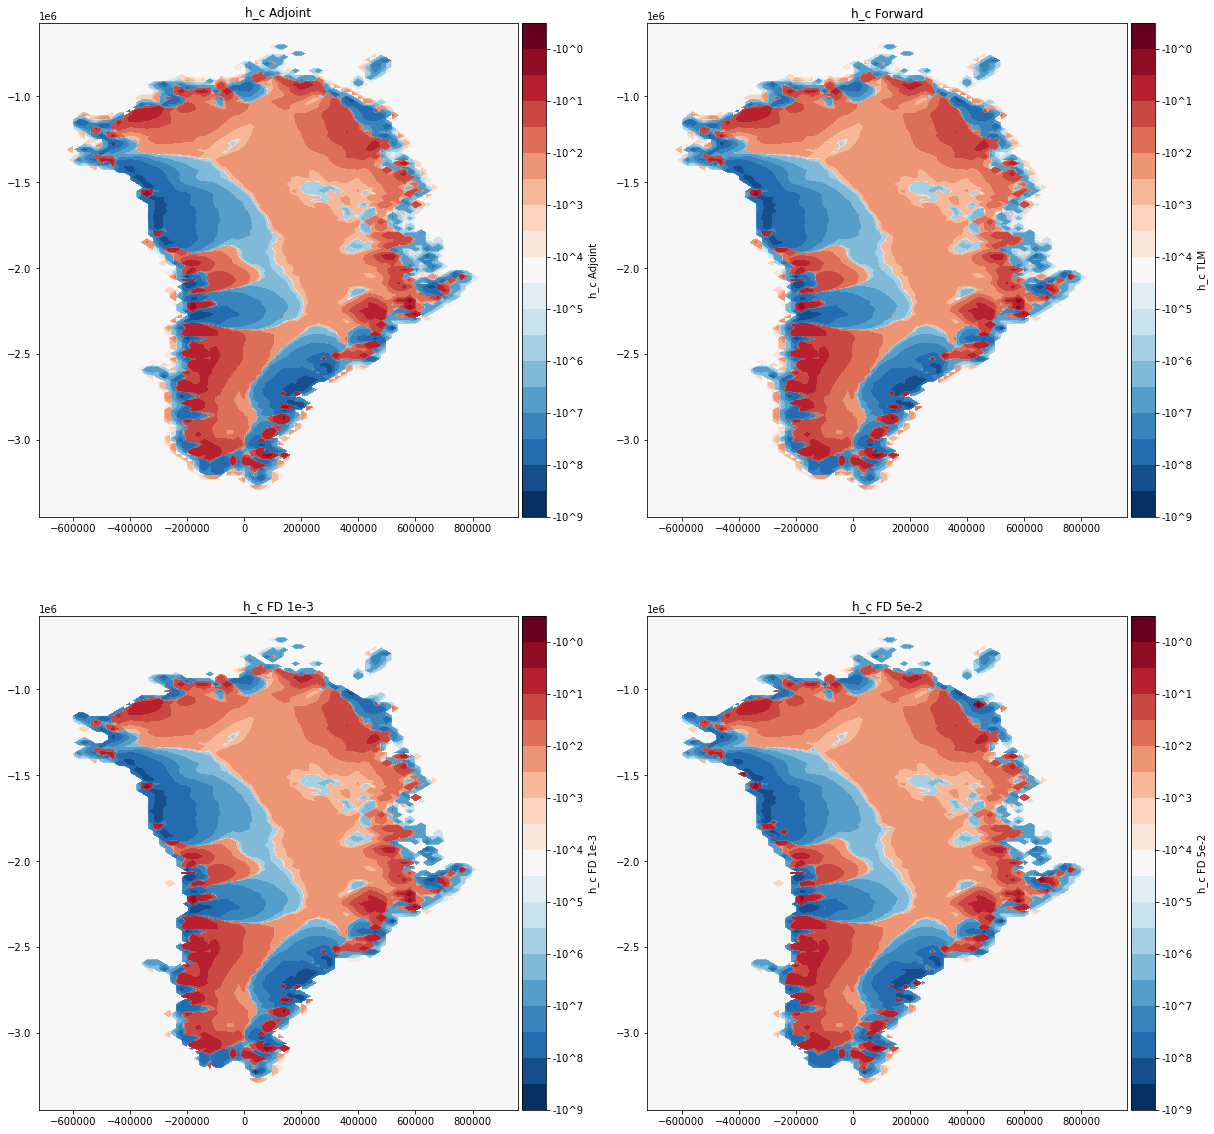

In [3]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(2,2)
plot_log(x,y,h_c_adjoint, bin_edges = np.arange(0,10), fig = fig, ax = ax[0,0], cbar_label = "h_c Adjoint")
plot_log(x,y,h_c_forward, bin_edges = np.arange(0,10), fig = fig, ax = ax[0,1], cbar_label = "h_c TLM")
plot_log(x,y,h_c_grdchk_1e3, bin_edges = np.arange(0,10), fig = fig, ax = ax[1,0], cbar_label = "h_c FD 1e-3")
plot_log(x,y,h_c_grdchk_5e2, bin_edges = np.arange(0,10), fig = fig, ax = ax[1,1], cbar_label = "h_c FD 5e-2")

ax[0,0].set_title("h_c Adjoint")
ax[0,1].set_title("h_c Forward")
ax[1,0].set_title("h_c FD 1e-3")
ax[1,1].set_title("h_c FD 5e-2")

<ipython-input-4-f93d8ee11f70>:3: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-h_c_grdchk_1e3/h_c_adjoint), nbins = 4, fig = fig, ax = ax[0,0], cbar_label = "h_c Adjoint")
<ipython-input-4-f93d8ee11f70>:4: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-h_c_grdchk_1e3/h_c_forward), nbins = 4, fig = fig, ax = ax[0,1], cbar_label = "h_c TLM")
<ipython-input-4-f93d8ee11f70>:5: RuntimeWarning: invalid value encountered in true_divide
  plot_normal(x,y,np.abs(1-h_c_grdchk_1e3/h_c_grdchk_1e3), nbins = 4, fig = fig, ax = ax[1,0], cbar_label = "h_c FD 1e-3")
<ipython-input-4-f93d8ee11f70>:6: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,1-h_c_grdchk_1e3/h_c_grdchk_5e2, nbins = 4, fig = fig, ax = ax[1,1], cbar_label = "h_c FD 5e-2")


Text(0.5, 1.0, 'h_c FD 5e-2')

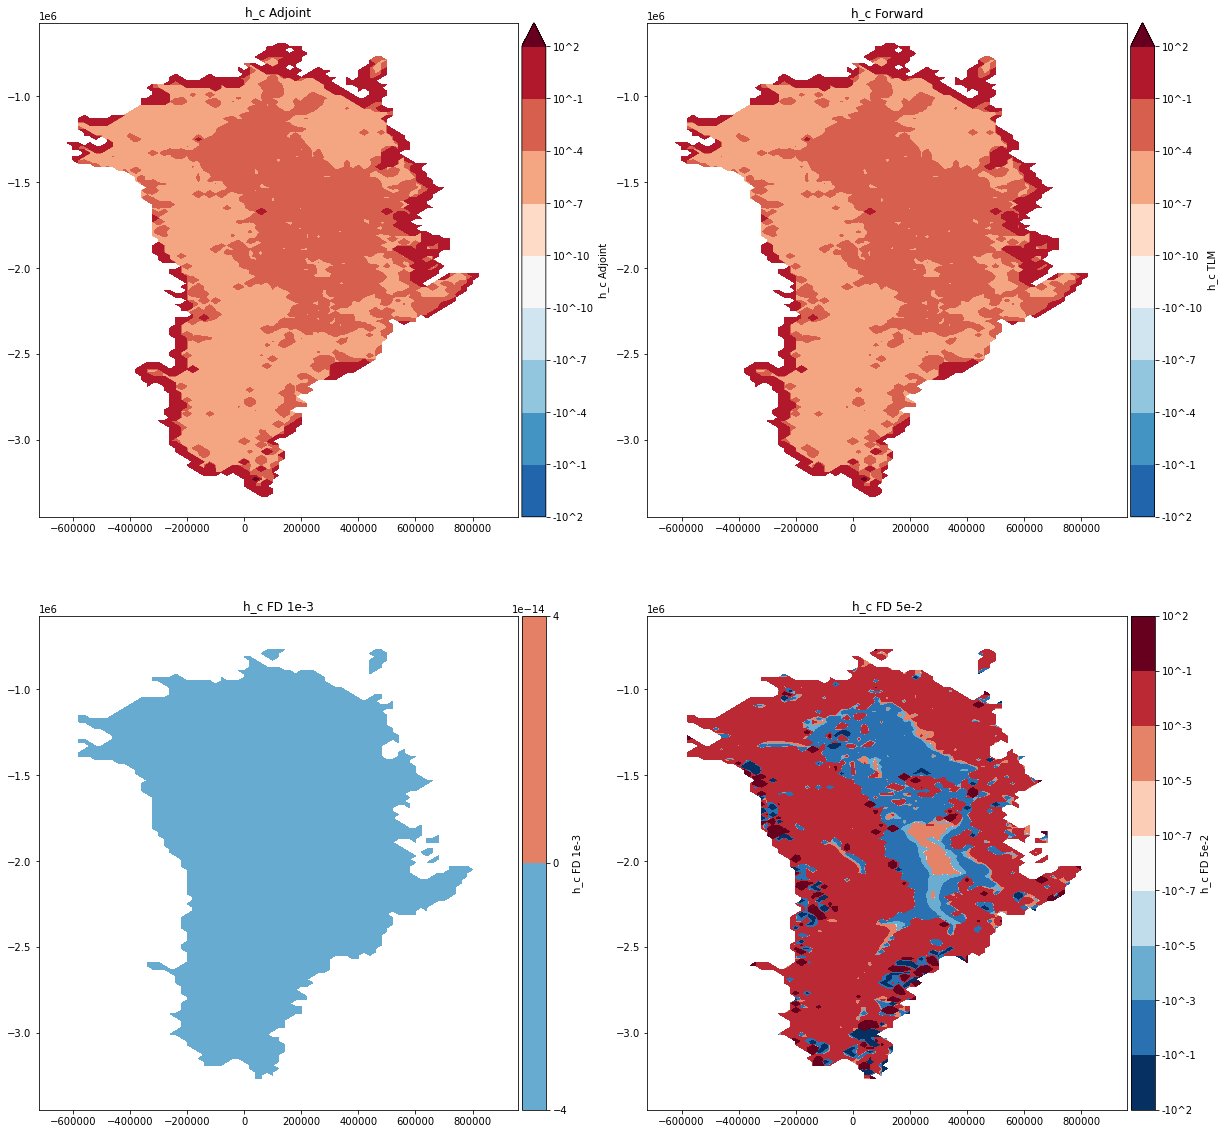

In [4]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(2,2)
plot_log(x,y,np.abs(1-h_c_grdchk_1e3/h_c_adjoint), nbins = 4, fig = fig, ax = ax[0,0], cbar_label = "h_c Adjoint")
plot_log(x,y,np.abs(1-h_c_grdchk_1e3/h_c_forward), nbins = 4, fig = fig, ax = ax[0,1], cbar_label = "h_c TLM")
plot_normal(x,y,np.abs(1-h_c_grdchk_1e3/h_c_grdchk_1e3), nbins = 4, fig = fig, ax = ax[1,0], cbar_label = "h_c FD 1e-3")
plot_log(x,y,1-h_c_grdchk_1e3/h_c_grdchk_5e2, nbins = 4, fig = fig, ax = ax[1,1], cbar_label = "h_c FD 5e-2")

ax[0,0].set_title("h_c Adjoint")
ax[0,1].set_title("h_c Forward")
ax[1,0].set_title("h_c FD 1e-3")
ax[1,1].set_title("h_c FD 5e-2")

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'vx_c FD 5e-2')

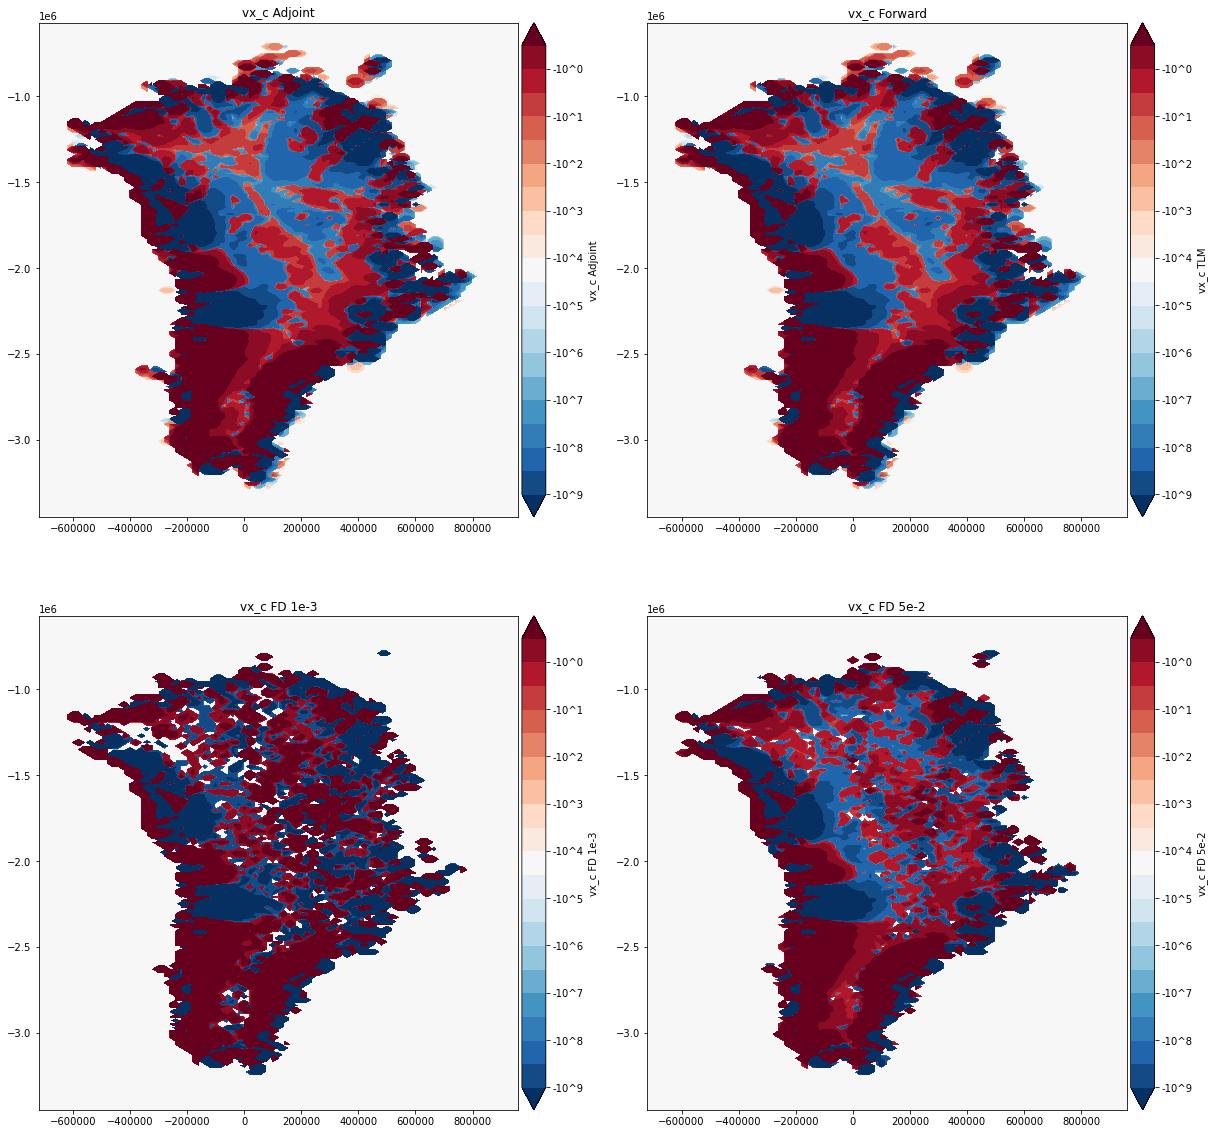

In [5]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(2,2)
plot_log(x,y,vx_c_adjoint, bin_edges = np.arange(0,10), fig = fig, ax = ax[0,0], cbar_label = "vx_c Adjoint")
plot_log(x,y,vx_c_forward, bin_edges = np.arange(0,10), fig = fig, ax = ax[0,1], cbar_label = "vx_c TLM")
plot_log(x,y,vx_c_grdchk_1e3, bin_edges = np.arange(0,10), fig = fig, ax = ax[1,0], cbar_label = "vx_c FD 1e-3")
plot_log(x,y,vx_c_grdchk_5e2, bin_edges = np.arange(0,10), fig = fig, ax = ax[1,1], cbar_label = "vx_c FD 5e-2")

ax[0,0].set_title("vx_c Adjoint")
ax[0,1].set_title("vx_c Forward")
ax[1,0].set_title("vx_c FD 1e-3")
ax[1,1].set_title("vx_c FD 5e-2")

<ipython-input-6-a0bdbb49f975>:3: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-vx_c_grdchk_1e3/vx_c_adjoint), nbins = 4, fig = fig, ax = ax[0,0], cbar_label = "vx_c Adjoint")
<ipython-input-6-a0bdbb49f975>:4: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-vx_c_grdchk_1e3/vx_c_forward), nbins = 4, fig = fig, ax = ax[0,1], cbar_label = "vx_c TLM")
<ipython-input-6-a0bdbb49f975>:5: RuntimeWarning: invalid value encountered in true_divide
  plot_normal(x,y,np.abs(1-vx_c_grdchk_1e3/vx_c_grdchk_1e3), nbins = 4, fig = fig, ax = ax[1,0], cbar_label = "vx_c FD 1e-3")
<ipython-input-6-a0bdbb49f975>:6: RuntimeWarning: divide by zero encountered in true_divide
  plot_log(x,y,1-vx_c_grdchk_1e3/vx_c_grdchk_5e2, nbins = 4, fig = fig, ax = ax[1,1], cbar_label = "vx_c FD 5e-2")
<ipython-input-6-a0bdbb49f975>:6: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,1-vx_c_grdchk_1e3/vx_c_grdchk_5e2, nbins = 4, fig = 

Text(0.5, 1.0, 'vx_c FD 5e-2')

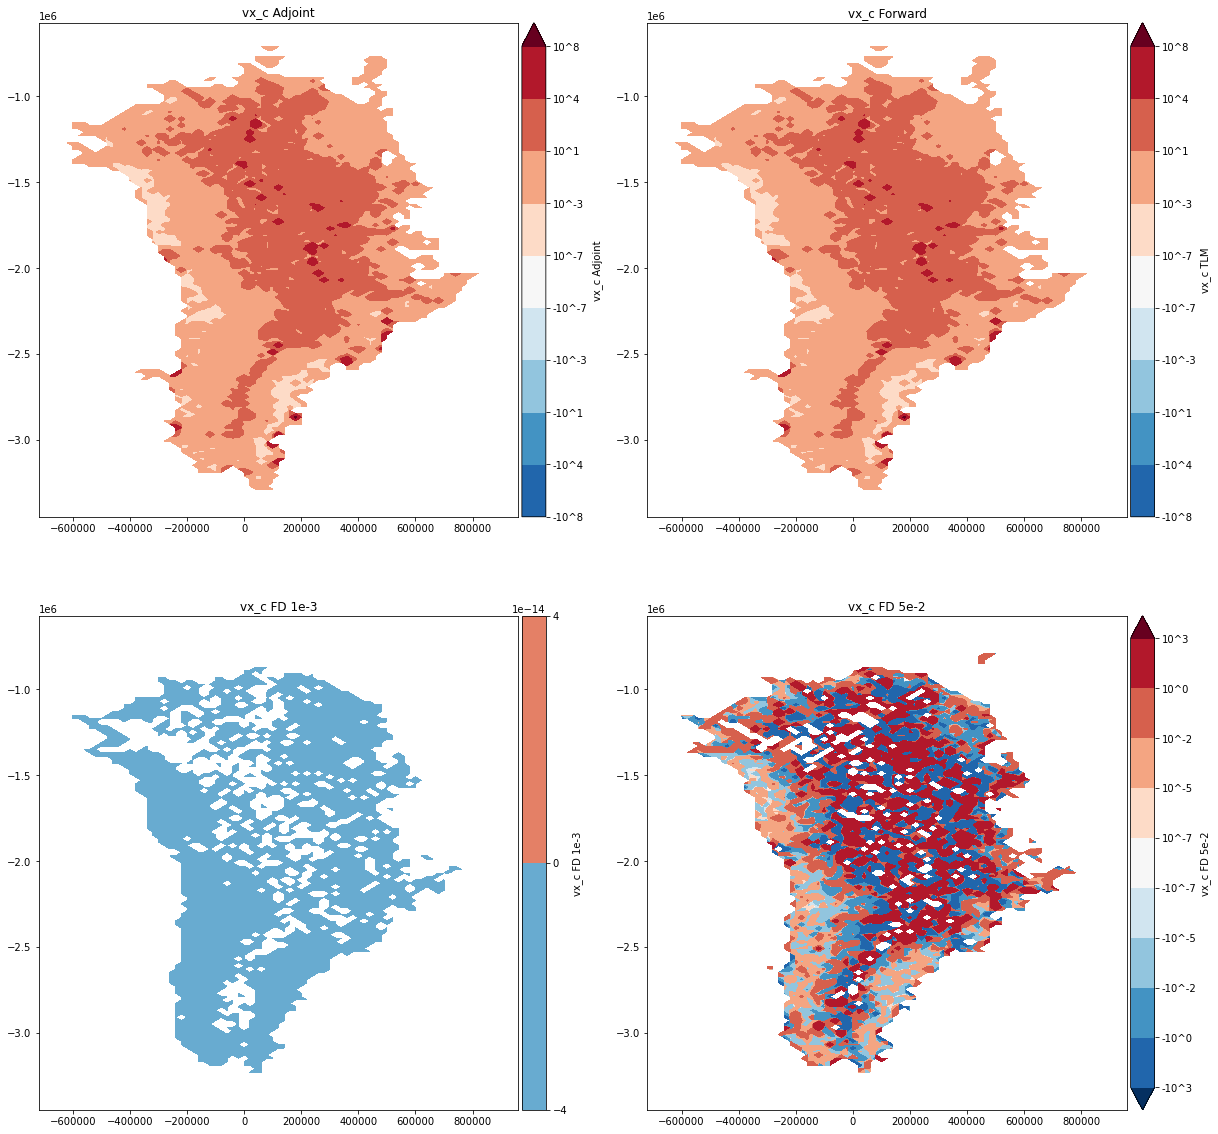

In [6]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(2,2)
plot_log(x,y,np.abs(1-vx_c_grdchk_1e3/vx_c_adjoint), nbins = 4, fig = fig, ax = ax[0,0], cbar_label = "vx_c Adjoint")
plot_log(x,y,np.abs(1-vx_c_grdchk_1e3/vx_c_forward), nbins = 4, fig = fig, ax = ax[0,1], cbar_label = "vx_c TLM")
plot_normal(x,y,np.abs(1-vx_c_grdchk_1e3/vx_c_grdchk_1e3), nbins = 4, fig = fig, ax = ax[1,0], cbar_label = "vx_c FD 1e-3")
plot_log(x,y,1-vx_c_grdchk_1e3/vx_c_grdchk_5e2, nbins = 4, fig = fig, ax = ax[1,1], cbar_label = "vx_c FD 5e-2")

ax[0,0].set_title("vx_c Adjoint")
ax[0,1].set_title("vx_c Forward")
ax[1,0].set_title("vx_c FD 1e-3")
ax[1,1].set_title("vx_c FD 5e-2")

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'q_geo FD 5e-2')

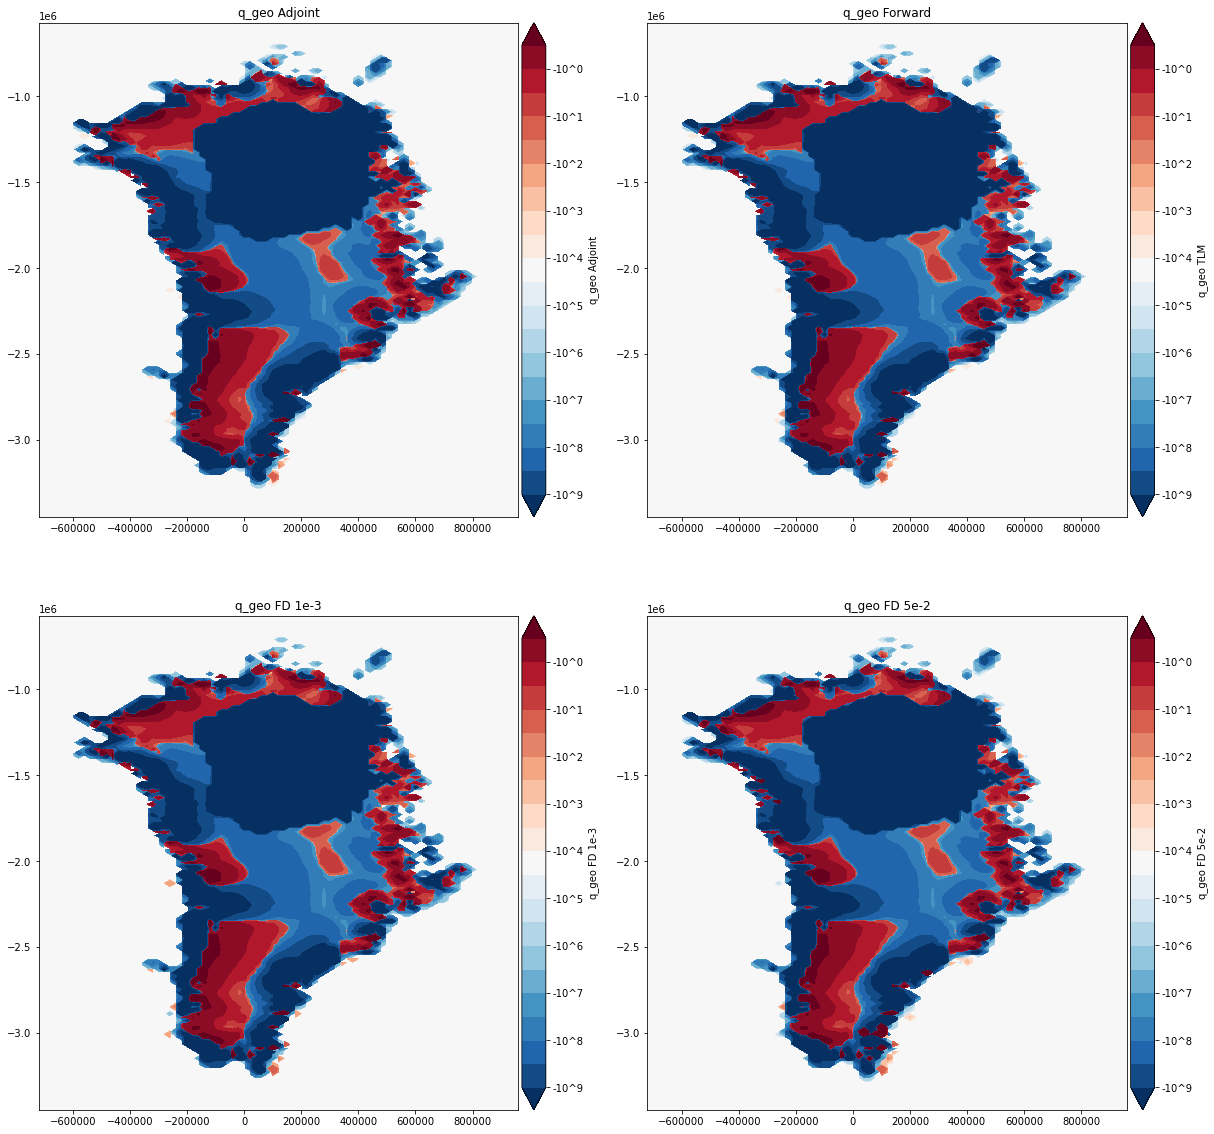

In [7]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(2,2)
plot_log(x,y,q_geo_adjoint, bin_edges = np.arange(0,10), fig = fig, ax = ax[0,0], cbar_label = "q_geo Adjoint")
plot_log(x,y,q_geo_forward, bin_edges = np.arange(0,10), fig = fig, ax = ax[0,1], cbar_label = "q_geo TLM")
plot_log(x,y,q_geo_grdchk_1e3, bin_edges = np.arange(0,10), fig = fig, ax = ax[1,0], cbar_label = "q_geo FD 1e-3")
plot_log(x,y,q_geo_grdchk_5e2, bin_edges = np.arange(0,10), fig = fig, ax = ax[1,1], cbar_label = "q_geo FD 5e-2")

ax[0,0].set_title("q_geo Adjoint")
ax[0,1].set_title("q_geo Forward")
ax[1,0].set_title("q_geo FD 1e-3")
ax[1,1].set_title("q_geo FD 5e-2")

<ipython-input-8-36b8de0d48b8>:3: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-q_geo_grdchk_1e3/q_geo_adjoint), nbins = 4, fig = fig, ax = ax[0,0], cbar_label = "q_geo Adjoint")
<ipython-input-8-36b8de0d48b8>:4: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-q_geo_grdchk_1e3/q_geo_forward), nbins = 4, fig = fig, ax = ax[0,1], cbar_label = "q_geo TLM")
<ipython-input-8-36b8de0d48b8>:5: RuntimeWarning: invalid value encountered in true_divide
  plot_normal(x,y,np.abs(1-q_geo_grdchk_1e3/q_geo_grdchk_1e3), nbins = 4, fig = fig, ax = ax[1,0], cbar_label = "q_geo FD 1e-3")
<ipython-input-8-36b8de0d48b8>:6: RuntimeWarning: divide by zero encountered in true_divide
  plot_log(x,y,1-q_geo_grdchk_1e3/q_geo_grdchk_5e2, nbins = 4, fig = fig, ax = ax[1,1], cbar_label = "q_geo FD 5e-2")
<ipython-input-8-36b8de0d48b8>:6: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,1-q_geo_grdchk_1e3/q_geo_grdchk_5e2, nbi

Text(0.5, 1.0, 'q_geo FD 5e-2')

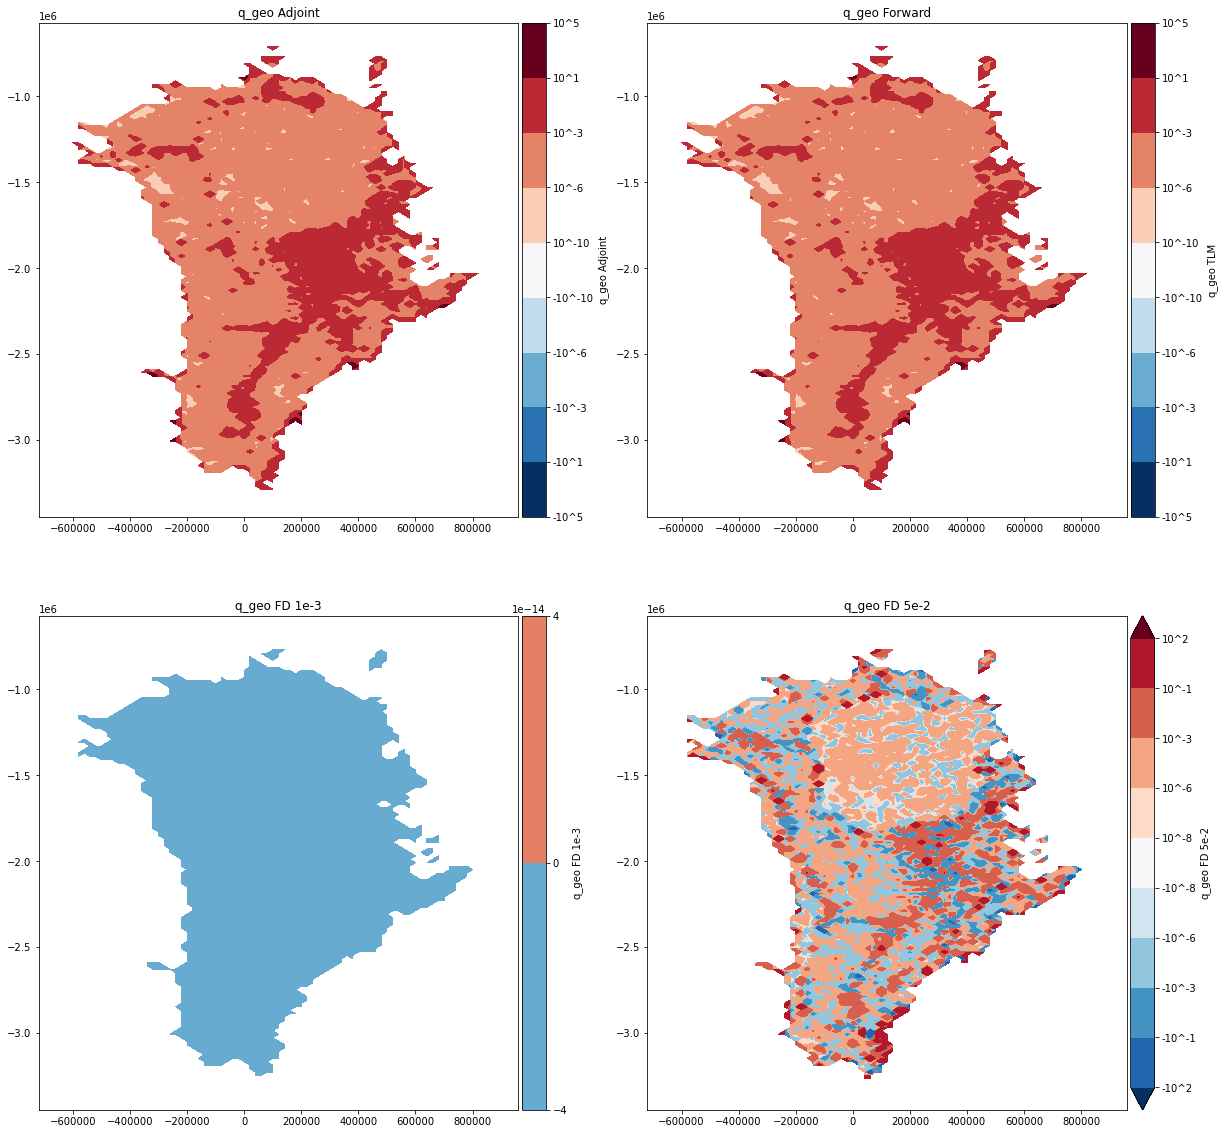

In [8]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(2,2)
plot_log(x,y,np.abs(1-q_geo_grdchk_1e3/q_geo_adjoint), nbins = 4, fig = fig, ax = ax[0,0], cbar_label = "q_geo Adjoint")
plot_log(x,y,np.abs(1-q_geo_grdchk_1e3/q_geo_forward), nbins = 4, fig = fig, ax = ax[0,1], cbar_label = "q_geo TLM")
plot_normal(x,y,np.abs(1-q_geo_grdchk_1e3/q_geo_grdchk_1e3), nbins = 4, fig = fig, ax = ax[1,0], cbar_label = "q_geo FD 1e-3")
plot_log(x,y,1-q_geo_grdchk_1e3/q_geo_grdchk_5e2, nbins = 4, fig = fig, ax = ax[1,1], cbar_label = "q_geo FD 5e-2")

ax[0,0].set_title("q_geo Adjoint")
ax[0,1].set_title("q_geo Forward")
ax[1,0].set_title("q_geo FD 1e-3")
ax[1,1].set_title("q_geo FD 5e-2")

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'dzs_dxi_g FD 5e-2')

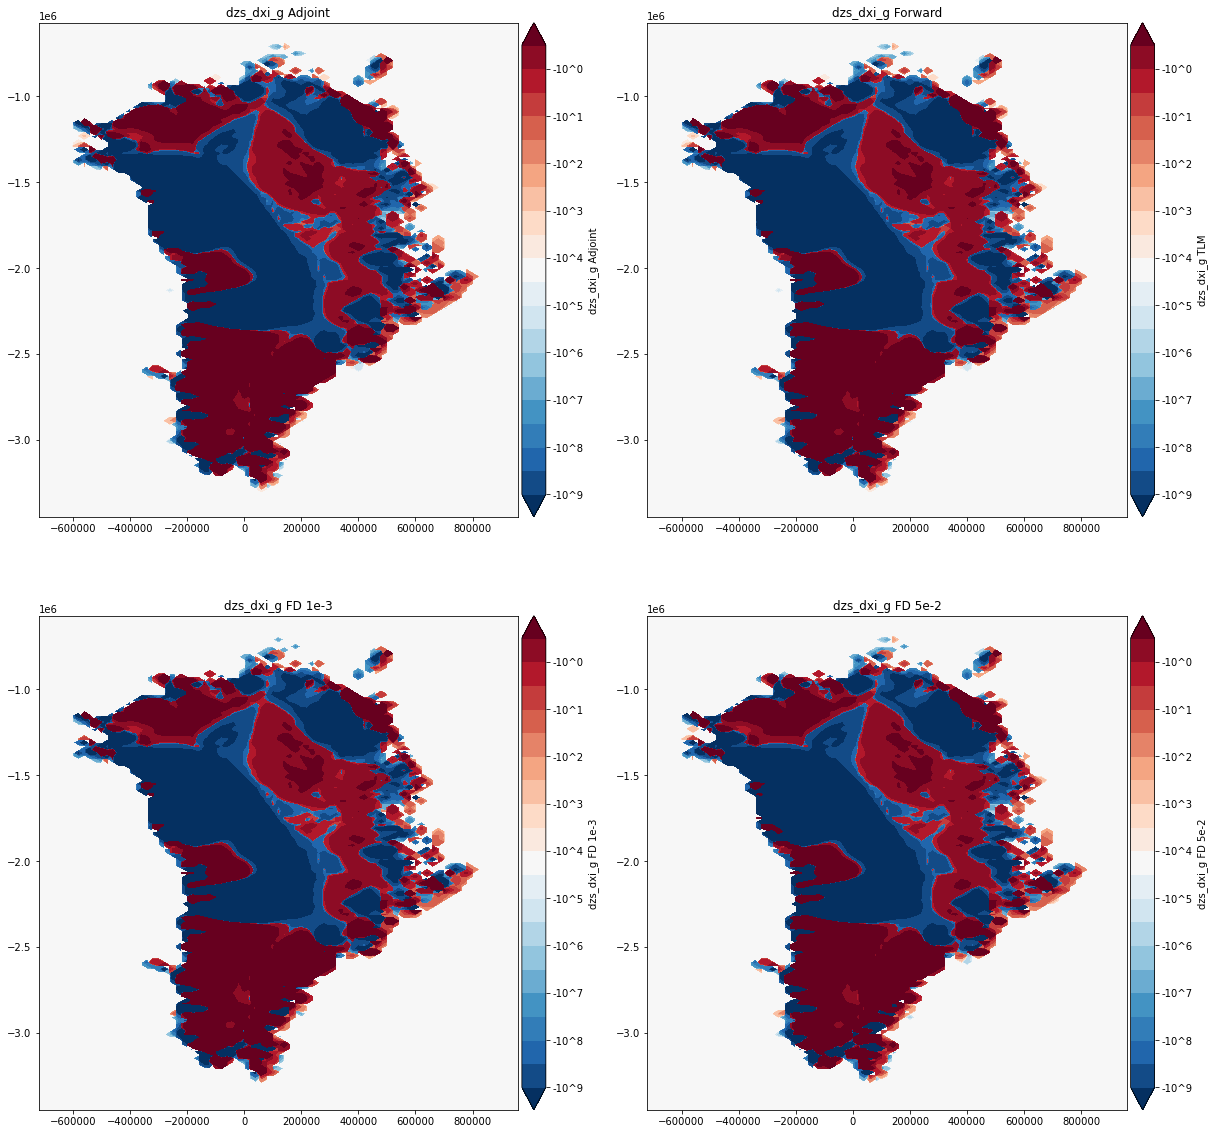

In [9]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(2,2)
plot_log(x,y,dzs_dxi_g_adjoint, bin_edges = np.arange(0,10), fig = fig, ax = ax[0,0], cbar_label = "dzs_dxi_g Adjoint")
plot_log(x,y,dzs_dxi_g_forward, bin_edges = np.arange(0,10), fig = fig, ax = ax[0,1], cbar_label = "dzs_dxi_g TLM")
plot_log(x,y,dzs_dxi_g_grdchk_1e3, bin_edges = np.arange(0,10), fig = fig, ax = ax[1,0], cbar_label = "dzs_dxi_g FD 1e-3")
plot_log(x,y,dzs_dxi_g_grdchk_5e2, bin_edges = np.arange(0,10), fig = fig, ax = ax[1,1], cbar_label = "dzs_dxi_g FD 5e-2")

ax[0,0].set_title("dzs_dxi_g Adjoint")
ax[0,1].set_title("dzs_dxi_g Forward")
ax[1,0].set_title("dzs_dxi_g FD 1e-3")
ax[1,1].set_title("dzs_dxi_g FD 5e-2")

<ipython-input-10-20e581fe7627>:3: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-dzs_dxi_g_grdchk_1e3/dzs_dxi_g_adjoint), nbins = 4, fig = fig, ax = ax[0,0], cbar_label = "dzs_dxi_g Adjoint")
<ipython-input-10-20e581fe7627>:4: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-dzs_dxi_g_grdchk_1e3/dzs_dxi_g_forward), nbins = 4, fig = fig, ax = ax[0,1], cbar_label = "dzs_dxi_g TLM")
<ipython-input-10-20e581fe7627>:5: RuntimeWarning: invalid value encountered in true_divide
  plot_normal(x,y,np.abs(1-dzs_dxi_g_grdchk_1e3/dzs_dxi_g_grdchk_1e3), nbins = 4, fig = fig, ax = ax[1,0], cbar_label = "dzs_dxi_g FD 1e-3")
<ipython-input-10-20e581fe7627>:6: RuntimeWarning: divide by zero encountered in true_divide
  plot_log(x,y,1-dzs_dxi_g_grdchk_1e3/dzs_dxi_g_grdchk_5e2, nbins = 4, fig = fig, ax = ax[1,1], cbar_label = "dzs_dxi_g FD 5e-2")
<ipython-input-10-20e581fe7627>:6: RuntimeWarning: invalid value encountered in true_divide
  

Text(0.5, 1.0, 'dzs_dxi_g FD 5e-2')

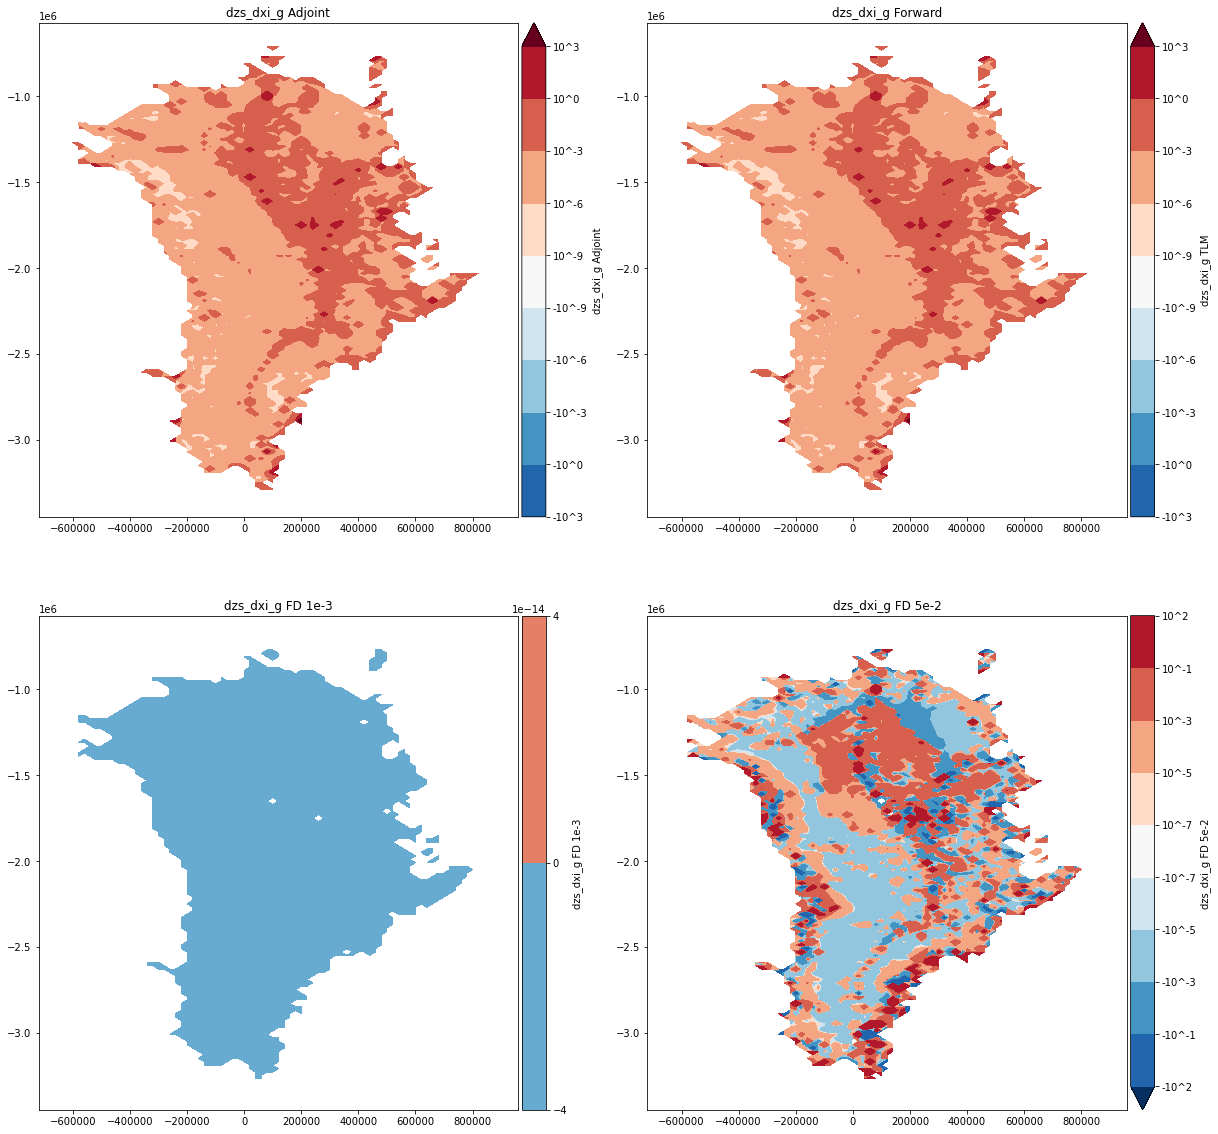

In [10]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(2,2)
plot_log(x,y,np.abs(1-dzs_dxi_g_grdchk_1e3/dzs_dxi_g_adjoint), nbins = 4, fig = fig, ax = ax[0,0], cbar_label = "dzs_dxi_g Adjoint")
plot_log(x,y,np.abs(1-dzs_dxi_g_grdchk_1e3/dzs_dxi_g_forward), nbins = 4, fig = fig, ax = ax[0,1], cbar_label = "dzs_dxi_g TLM")
plot_normal(x,y,np.abs(1-dzs_dxi_g_grdchk_1e3/dzs_dxi_g_grdchk_1e3), nbins = 4, fig = fig, ax = ax[1,0], cbar_label = "dzs_dxi_g FD 1e-3")
plot_log(x,y,1-dzs_dxi_g_grdchk_1e3/dzs_dxi_g_grdchk_5e2, nbins = 4, fig = fig, ax = ax[1,1], cbar_label = "dzs_dxi_g FD 5e-2")

ax[0,0].set_title("dzs_dxi_g Adjoint")
ax[0,1].set_title("dzs_dxi_g Forward")
ax[1,0].set_title("dzs_dxi_g FD 1e-3")
ax[1,1].set_title("dzs_dxi_g FD 5e-2")

In [11]:
flags_file = "flags.dat"
# Read in the file
with open(flags_file, 'r') as file :
    filedata = file.read()

# Replace the target string
filedata = filedata.replace('F', '0')
filedata = filedata.replace('T', '1')

# Write the file out again
with open(flags_file, 'w') as file:
    file.write(filedata)

In [12]:
data = np.loadtxt(flags_file, skiprows = 2)

x = np.unique(data[:,0])
y = np.unique(data[:,1])
maske = np.reshape(data[:,2], [len(x),len(y)]).T
maske_neu = np.reshape(data[:,3], [len(x),len(y)]).T
maske_old = np.reshape(data[:,4], [len(x),len(y)]).T
vx_c = np.reshape(data[:,5], [len(x),len(y)]).T
h_c = np.reshape(data[:,6], [len(x),len(y)]).T

/Users/shreyas/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
<ipython-input-13-4fb9c38e39c0>:10: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-h_c_grdchk_1e3/h_c_adjoint), nbins = 4, fig = fig, ax = ax[1], cbar_label = "h_c Adjoint")


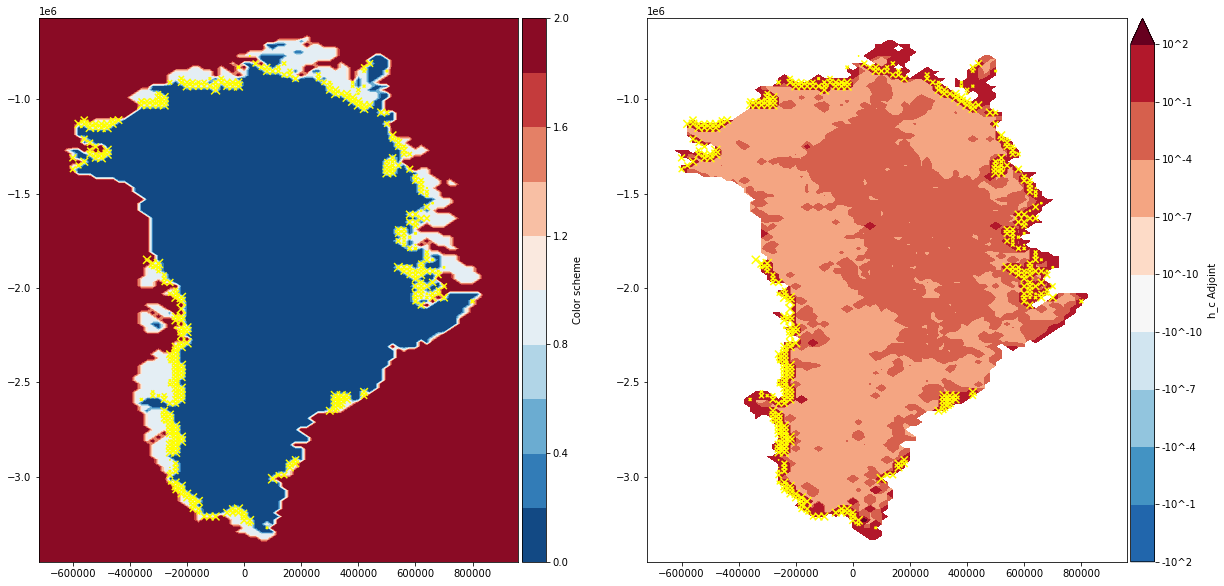

In [13]:
plt.rcParams['figure.figsize'] = [20, 10]
flag1 = h_c_grdchk_1e3 == 0.0
flag2 = h_c_adjoint != 0.0
flag_h_c = flag1 & flag2
y_scatter, x_scatter = np.nonzero(flag_h_c)

fig, ax = plt.subplots(1,2)
plot_normal(x,y,maske, nbins = 10, fig = fig, ax = ax[0])
ax[0].scatter(x[x_scatter], y[y_scatter], marker = 'x', c='yellow', s=7*np.log(np.abs(h_c_adjoint[y_scatter, x_scatter])))
plot_log(x,y,np.abs(1-h_c_grdchk_1e3/h_c_adjoint), nbins = 4, fig = fig, ax = ax[1], cbar_label = "h_c Adjoint")
ax[1].scatter(x[x_scatter], y[y_scatter], marker = 'x', c='yellow', s=7*np.log(np.abs(h_c_adjoint[y_scatter, x_scatter])))

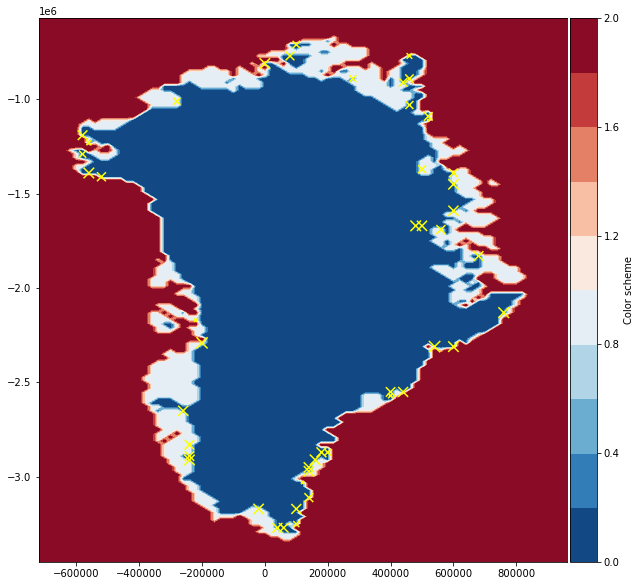

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]
flag1 = q_geo_grdchk_1e3 == 0.0
flag2 = q_geo_adjoint != 0.0
flag_q_geo = flag1 & flag2
y_scatter, x_scatter = np.nonzero(flag_q_geo)

fig, ax = plt.subplots()
plot_normal(x,y,maske, nbins = 10, fig = fig, ax = ax)
ax.scatter(x[x_scatter], y[y_scatter], marker = 'x', c='yellow', s=15*np.log(np.abs(q_geo_adjoint[y_scatter, x_scatter])))

<ipython-input-15-be1f8e2378f2>:10: RuntimeWarning: invalid value encountered in true_divide
  plot_log(x,y,np.abs(1-vx_c_grdchk_1e3/vx_c_adjoint), nbins = 4, fig = fig, ax = ax[1], cbar_label = "vx_c Adjoint")


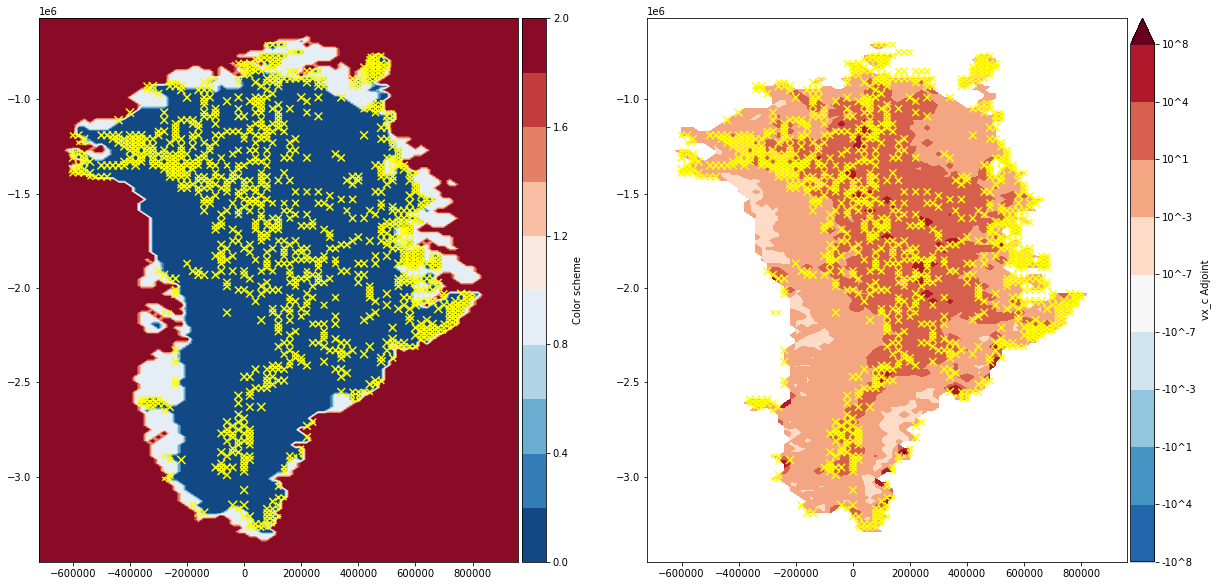

In [15]:
plt.rcParams['figure.figsize'] = [20, 10]
flag1 = vx_c_grdchk_1e3 == 0.0
flag2 = vx_c_adjoint != 0.0
flag_vx_c = flag1 & flag2
y_scatter, x_scatter = np.nonzero(flag_vx_c)

fig, ax = plt.subplots(1,2)
plot_normal(x,y,maske, nbins = 10, fig = fig, ax = ax[0])
ax[0].scatter(x[x_scatter], y[y_scatter], marker = 'x', c='yellow', s=3*np.log(np.abs(vx_c_adjoint[y_scatter, x_scatter])))
plot_log(x,y,np.abs(1-vx_c_grdchk_1e3/vx_c_adjoint), nbins = 4, fig = fig, ax = ax[1], cbar_label = "vx_c Adjoint")
ax[1].scatter(x[x_scatter], y[y_scatter], marker = 'x', c='yellow', s=3*np.log(np.abs(vx_c_adjoint[y_scatter, x_scatter])))

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


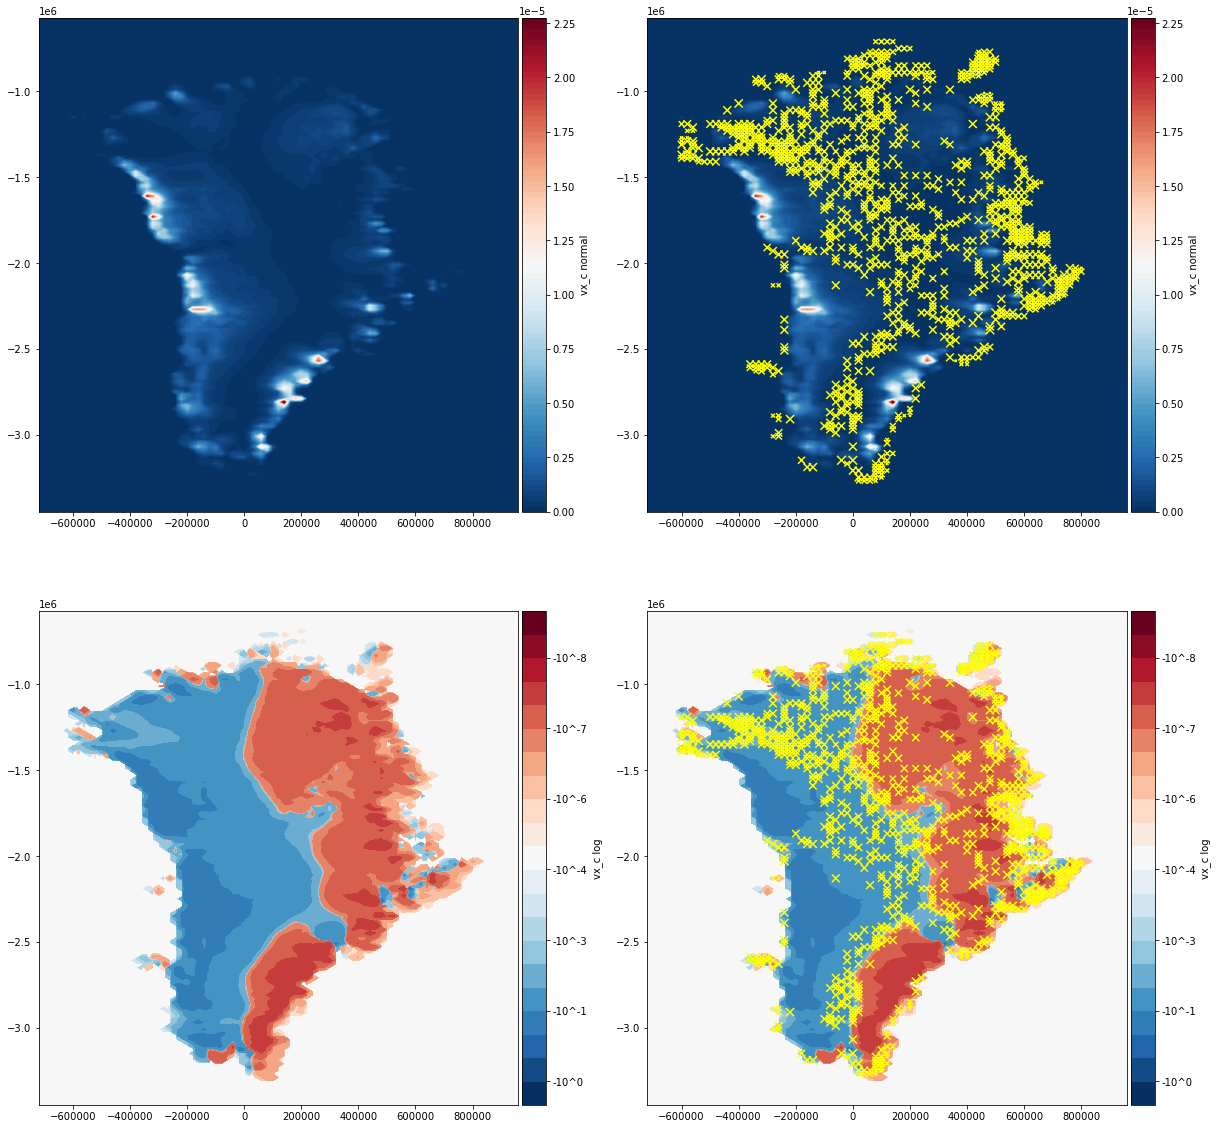

In [16]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(2,2)
plot_normal(x,y,np.abs(vx_c), nbins = 100, fig = fig, ax = ax[0,0], cbar_label = "vx_c normal")
plot_normal(x,y,np.abs(vx_c), nbins = 100, fig = fig, ax = ax[0,1], cbar_label = "vx_c normal")
ax[0,1].scatter(x[x_scatter], y[y_scatter], marker = 'x', c='yellow', s=3*np.log(np.abs(vx_c_adjoint[y_scatter, x_scatter])))


plot_log(x,y,vx_c, nbins = 10, fig = fig, ax = ax[1,1], cbar_label = "vx_c log")
plot_log(x,y,vx_c, nbins = 10, fig = fig, ax = ax[1,0], cbar_label = "vx_c log")
ax[1,1].scatter(x[x_scatter], y[y_scatter], marker = 'x', c='yellow', s=3*np.log(np.abs(vx_c_adjoint[y_scatter, x_scatter])))



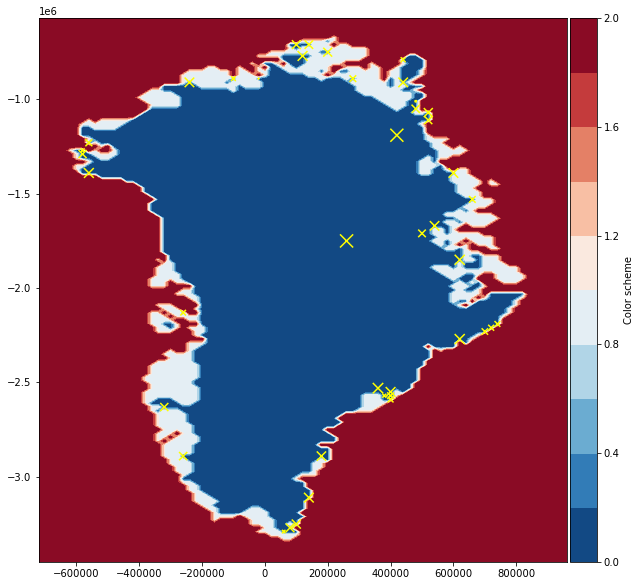

In [17]:
plt.rcParams['figure.figsize'] = [10, 10]
flag1 = dzs_dxi_g_grdchk_1e3 == 0.0
flag2 = dzs_dxi_g_adjoint != 0.0
flag_dzs_dxi_g = flag1 & flag2
y_scatter, x_scatter = np.nonzero(flag_dzs_dxi_g)

fig, ax = plt.subplots()
plot_normal(x,y,maske, nbins = 10, fig = fig, ax = ax)
ax.scatter(x[x_scatter], y[y_scatter], marker = 'x', c='yellow', s=10*np.log(np.abs(dzs_dxi_g_adjoint[y_scatter, x_scatter])))



In [18]:
filename = "results_ant20_shelves_OAD/h_c_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)

x = np.unique(data[:,0])
y = np.unique(data[:,1])
ant_h_c_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "results_ant20_shelves_OAD/vx_c_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)
ant_vx_c_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "results_ant20_shelves_OAD/q_geo_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)
ant_q_geo_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "results_ant20_shelves_OAD/dzs_dxi_g_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)
ant_dzs_dxi_g_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T


<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'h_c Adjoint normal')

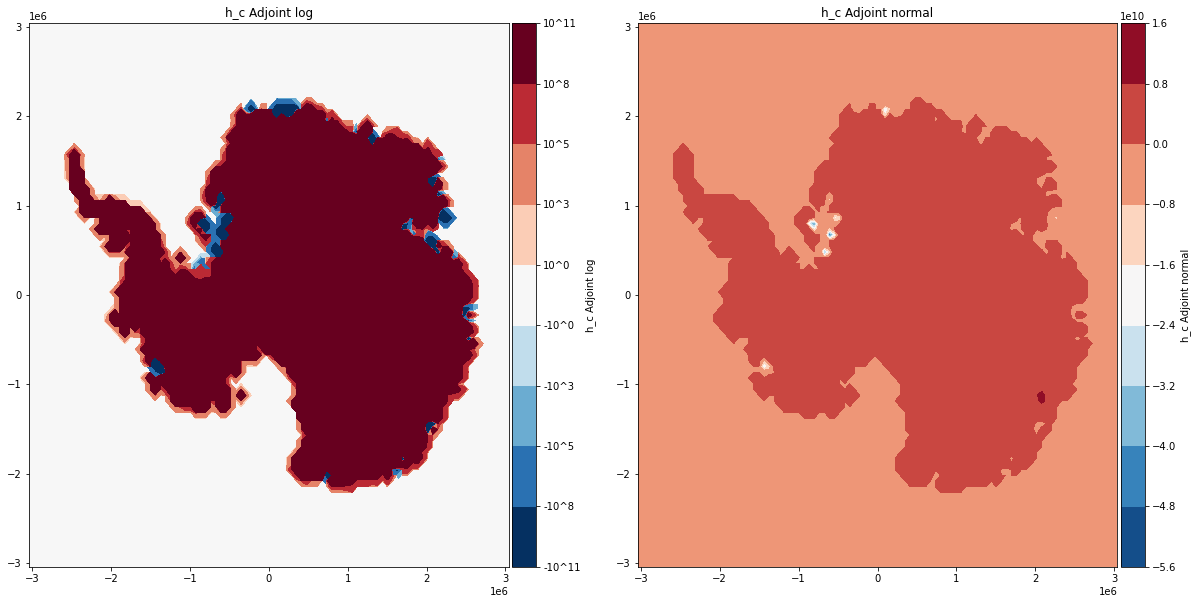

In [24]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1,2)
plot_log(x,y,ant_h_c_adjoint, nbins = 4, fig = fig, ax = ax[0], cbar_label = "h_c Adjoint log")
plot_normal(x,y,ant_h_c_adjoint, nbins = 10, fig = fig, ax = ax[1], cbar_label = "h_c Adjoint normal")
ax[0].set_title("h_c Adjoint log")
ax[1].set_title("h_c Adjoint normal")

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'q_geo Adjoint normal')

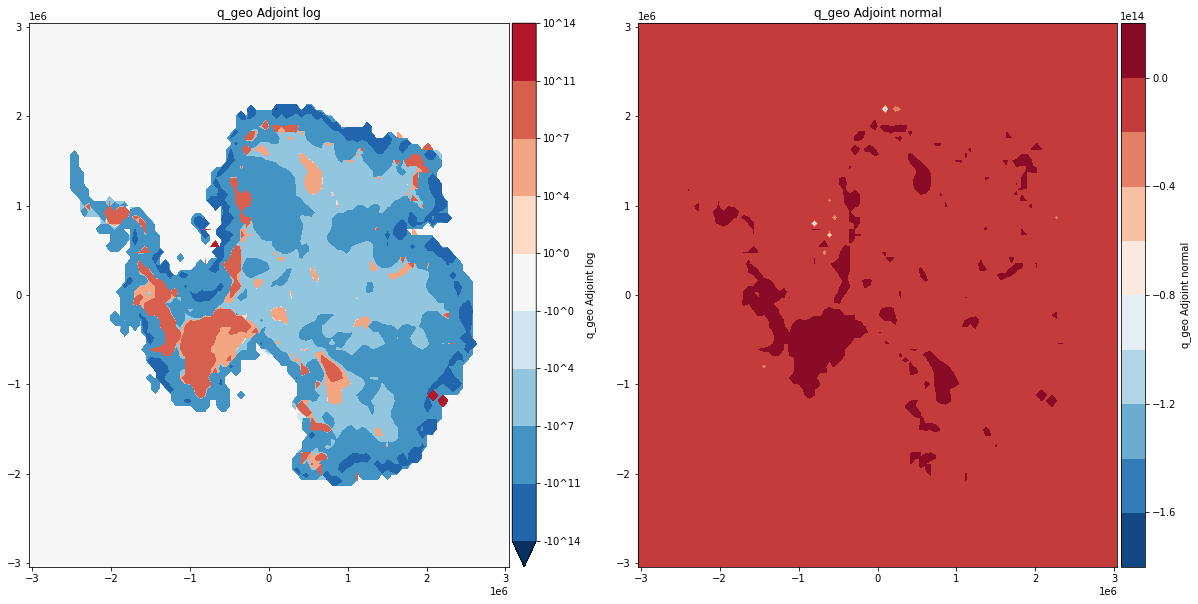

In [25]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1,2)
plot_log(x,y,ant_q_geo_adjoint, nbins = 4, fig = fig, ax = ax[0], cbar_label = "q_geo Adjoint log")
plot_normal(x,y,ant_q_geo_adjoint, nbins = 10, fig = fig, ax = ax[1], cbar_label = "q_geo Adjoint normal")
ax[0].set_title("q_geo Adjoint log")
ax[1].set_title("q_geo Adjoint normal")

Text(0.5, 1.0, 'vx_c Adjoint normal')

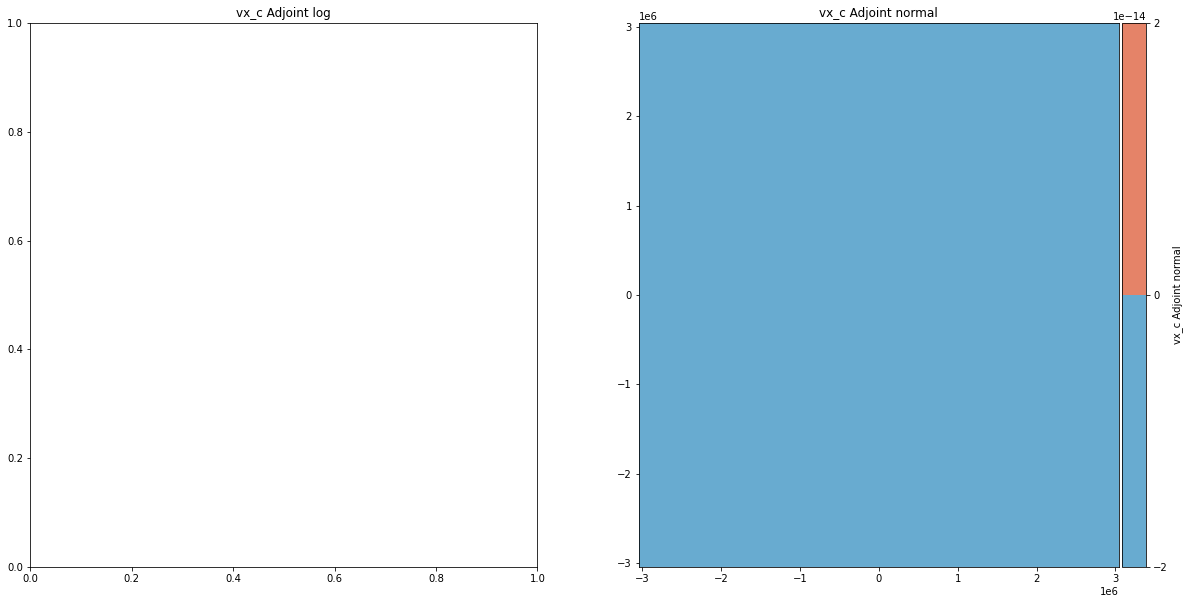

In [28]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1,2)
#plot_log(x,y,ant_vx_c_adjoint, nbins = 1, fig = fig, ax = ax[0], cbar_label = "vx_c Adjoint log")
plot_normal(x,y,ant_vx_c_adjoint, nbins = 10, fig = fig, ax = ax[1], cbar_label = "vx_c Adjoint normal")
ax[0].set_title("vx_c Adjoint log")
ax[1].set_title("vx_c Adjoint normal")

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'dzs_dxi_g Adjoint normal')

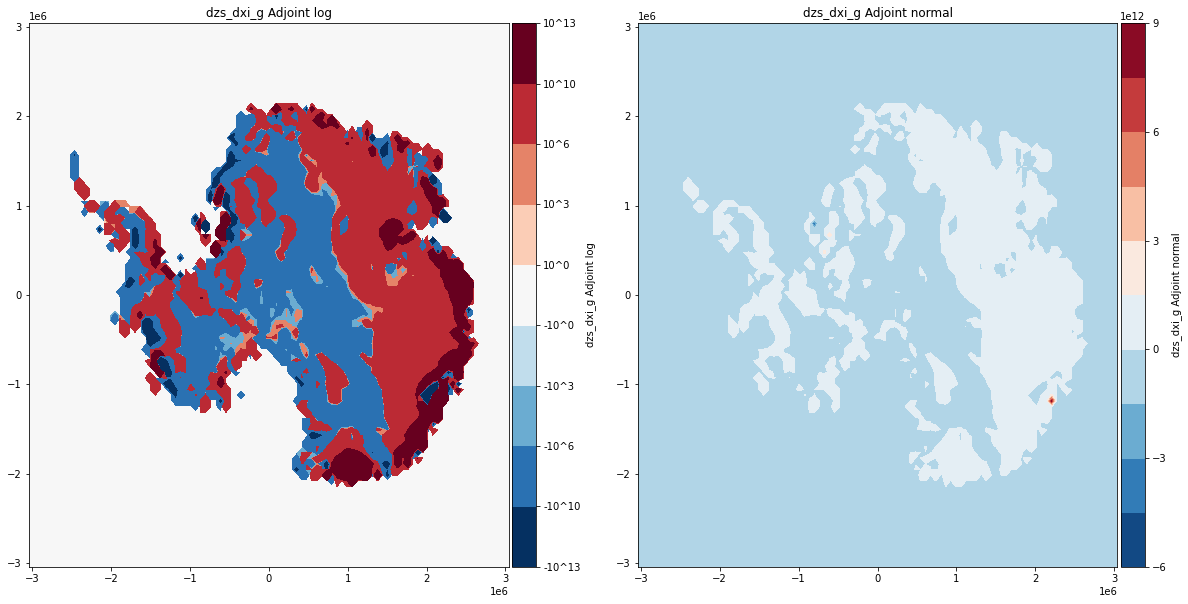

In [30]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1,2)
plot_log(x,y,ant_dzs_dxi_g_adjoint, nbins = 4, fig = fig, ax = ax[0], cbar_label = "dzs_dxi_g Adjoint log")
plot_normal(x,y,ant_dzs_dxi_g_adjoint, nbins = 10, fig = fig, ax = ax[1], cbar_label = "dzs_dxi_g Adjoint normal")
ax[0].set_title("dzs_dxi_g Adjoint log")
ax[1].set_title("dzs_dxi_g Adjoint normal")

In [31]:
filename = "results_ant40_ss25ka/h_c_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)

x = np.unique(data[:,0])
y = np.unique(data[:,1])
ant_h_c_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "results_ant40_ss25ka/vx_c_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)
ant_vx_c_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "results_ant40_ss25ka/q_geo_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)
ant_q_geo_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T

filename = "results_ant40_ss25ka/dzs_dxi_g_adjoint.dat"
data = np.loadtxt(filename, skiprows = 2)
ant_dzs_dxi_g_adjoint = np.reshape(data[:,-1], [len(x),len(y)]).T


<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'h_c Adjoint normal')

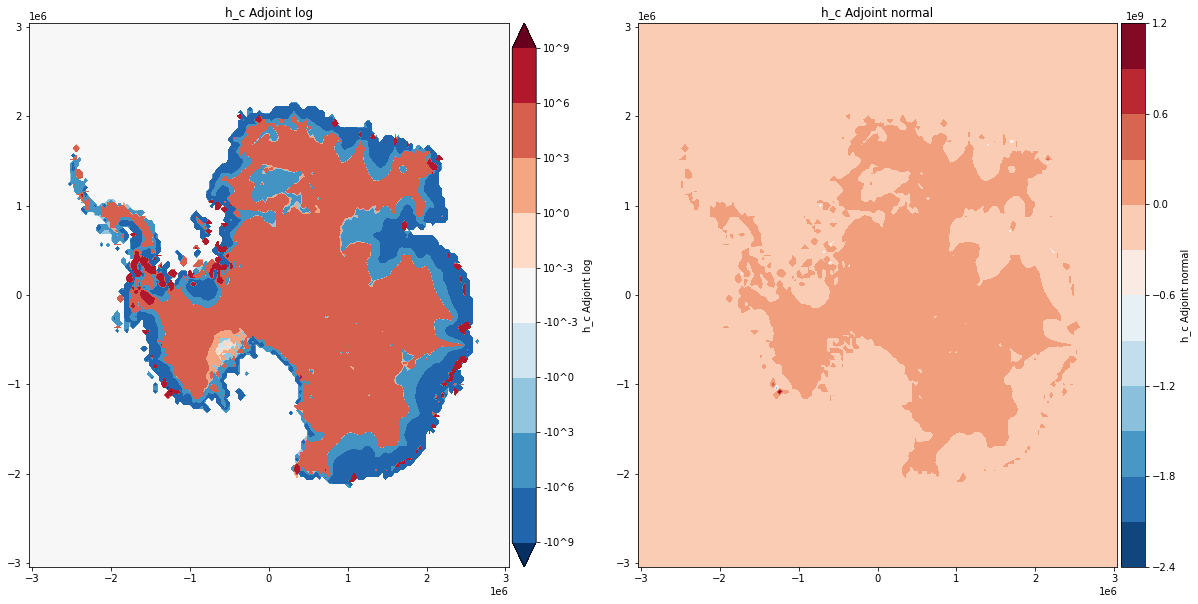

In [32]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1,2)
plot_log(x,y,ant_h_c_adjoint, nbins = 4, fig = fig, ax = ax[0], cbar_label = "h_c Adjoint log")
plot_normal(x,y,ant_h_c_adjoint, nbins = 10, fig = fig, ax = ax[1], cbar_label = "h_c Adjoint normal")
ax[0].set_title("h_c Adjoint log")
ax[1].set_title("h_c Adjoint normal")

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'q_geo Adjoint normal')

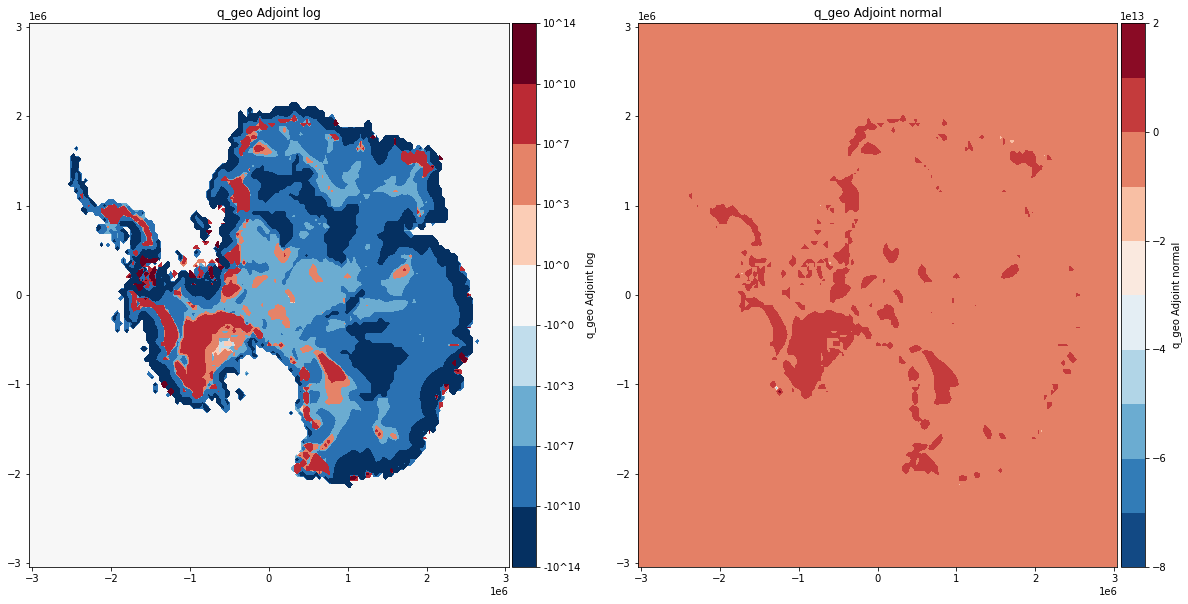

In [33]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1,2)
plot_log(x,y,ant_q_geo_adjoint, nbins = 4, fig = fig, ax = ax[0], cbar_label = "q_geo Adjoint log")
plot_normal(x,y,ant_q_geo_adjoint, nbins = 10, fig = fig, ax = ax[1], cbar_label = "q_geo Adjoint normal")
ax[0].set_title("q_geo Adjoint log")
ax[1].set_title("q_geo Adjoint normal")

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'vx_c Adjoint normal')

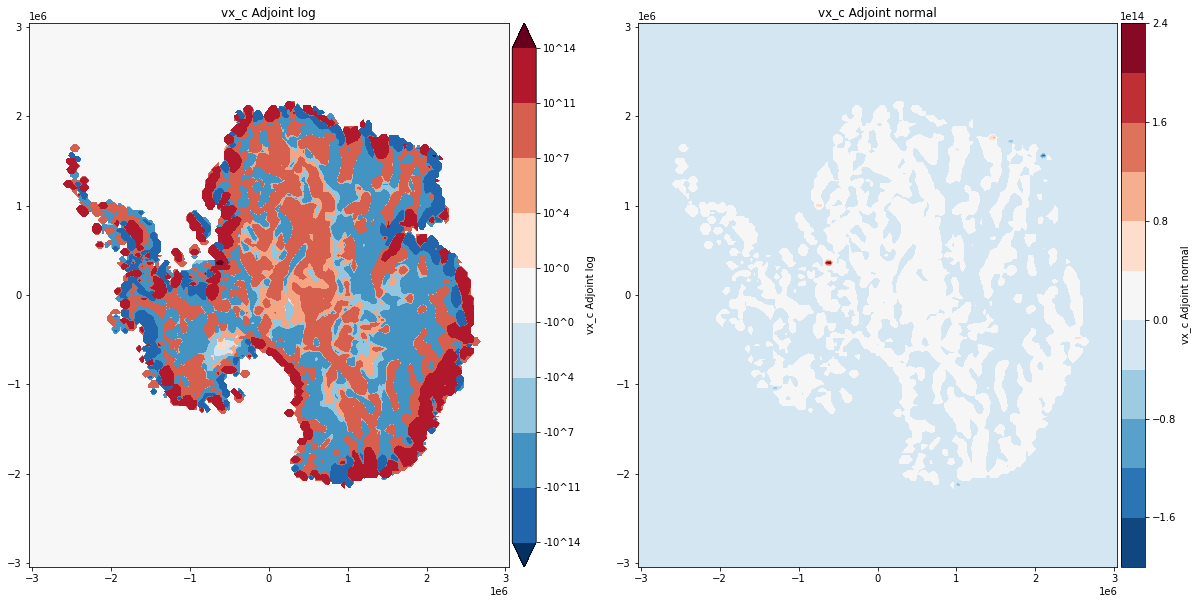

In [39]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1,2)
plot_log(x,y,ant_vx_c_adjoint, nbins = 4, fig = fig, ax = ax[0], cbar_label = "vx_c Adjoint log")
plot_normal(x,y,ant_vx_c_adjoint, nbins = 10, fig = fig, ax = ax[1], cbar_label = "vx_c Adjoint normal")
ax[0].set_title("vx_c Adjoint log")
ax[1].set_title("vx_c Adjoint normal")

<ipython-input-1-80a6300f2707>:112: RuntimeWarning: divide by zero encountered in log10
  log = np.log10(np.abs(data))


Text(0.5, 1.0, 'dzs_dxi_g Adjoint normal')

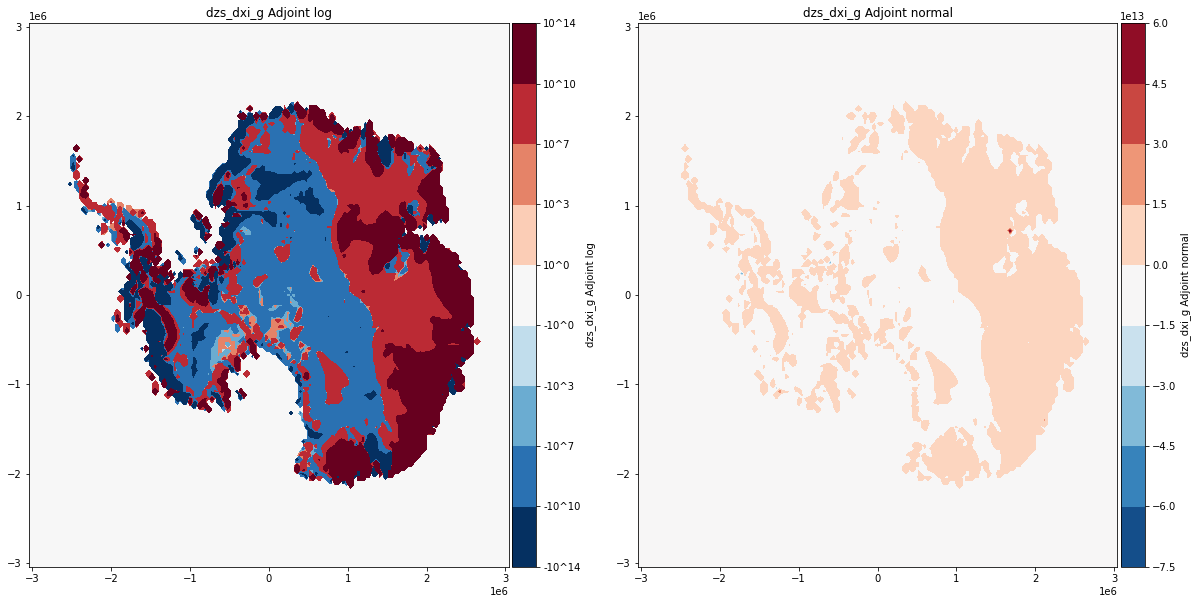

In [36]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1,2)
plot_log(x,y,ant_dzs_dxi_g_adjoint, nbins = 4, fig = fig, ax = ax[0], cbar_label = "dzs_dxi_g Adjoint log")
plot_normal(x,y,ant_dzs_dxi_g_adjoint, nbins = 10, fig = fig, ax = ax[1], cbar_label = "dzs_dxi_g Adjoint normal")
ax[0].set_title("dzs_dxi_g Adjoint log")
ax[1].set_title("dzs_dxi_g Adjoint normal")